/opt/anaconda3/envs/research/lib/python3.11/site-packages/gstools/field/plot.py:110: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


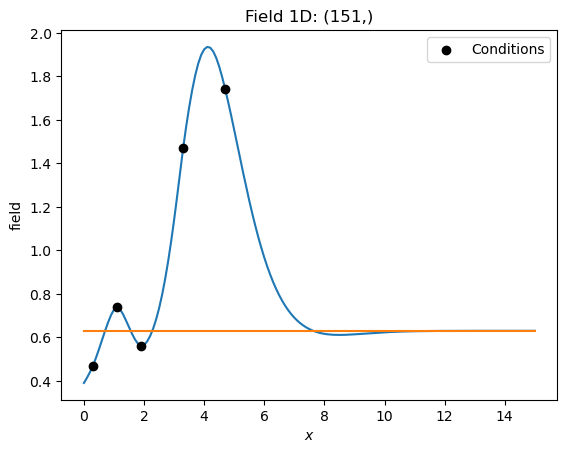

In [1]:
r"""
Log-Normal Kriging
------------------

Log Normal kriging is a term to describe a special workflow for kriging to
deal with log-normal data, like conductivity or transmissivity in hydrogeology.

It simply means to first convert the input data to a normal distribution, i.e.
applying a logarithic function, then interpolating these values with kriging
and transforming the result back with the exponential function.

The resulting kriging variance describes the error variance of the log-values
of the target variable.

In this example we will use ordinary kriging.
"""
import numpy as np

import gstools as gs

# condtions
cond_pos = [0.3, 1.9, 1.1, 3.3, 4.7]
cond_val = [0.47, 0.56, 0.74, 1.47, 1.74]
# resulting grid
gridx = np.linspace(0.0, 15.0, 151)
# stable covariance model
model = gs.Stable(dim=1, var=0.5, len_scale=2.56, alpha=1.9)

###############################################################################
# In order to result in log-normal kriging, we will use the :any:`LogNormal`
# Normalizer. This is a parameter-less normalizer, so we don't have to fit it.
normalizer = gs.normalizer.LogNormal

###############################################################################
# Now we generate the interpolated field as well as the mean field.
# This can be done by setting `only_mean=True` in :any:`Krige.__call__`.
# The result is then stored as `mean_field`.
#
# In terms of log-normal kriging, this mean represents the geometric mean of
# the field.
krige = gs.krige.Ordinary(model, cond_pos, cond_val, normalizer=normalizer)
# interpolate the field
krige(gridx)
# also generate the mean field
krige(gridx, only_mean=True)

###############################################################################
# And that's it. Let's have a look at the results.
ax = krige.plot()
# plotting the geometric mean
krige.plot("mean_field", ax=ax)
# plotting the conditioning data
ax.scatter(cond_pos, cond_val, color="k", zorder=10, label="Conditions")
ax.legend()


Stable(dim=2, var=0.576, len_scale=8.85, nugget=0.00682, alpha=2.0)
BoxCox(lmbda=-0.0754)


[None, None, None]

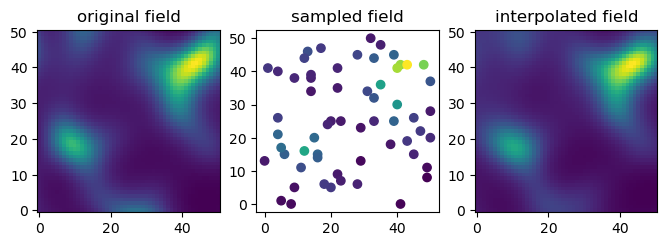

In [2]:
"""
Automatic fitting
-----------------

In order to demonstrate how to automatically fit normalizer and variograms,
we generate synthetic log-normal data, that should be interpolated with
ordinary kriging.

Normalizers are fitted by minimizing the likelihood function and variograms
are fitted by estimating the empirical variogram with automatic binning and
fitting the theoretical model to it. Thereby the sill is constrained to match
the field variance.

Artificial data
^^^^^^^^^^^^^^^

Here we generate log-normal data following a Gaussian covariance model.
We will generate the "original" field on a 60x60 mesh, from which we will take
samples in order to pretend a situation of data-scarcity.
"""
import matplotlib.pyplot as plt
import numpy as np

import gstools as gs

# structured field with edge length of 50
x = y = range(51)
pos = gs.generate_grid([x, y])
model = gs.Gaussian(dim=2, var=1, len_scale=10)
srf = gs.SRF(model, seed=20170519, normalizer=gs.normalizer.LogNormal())
# generate the original field
srf(pos)

###############################################################################
# Here, we sample 60 points and set the conditioning points and values.

ids = np.arange(srf.field.size)
samples = np.random.RandomState(20210201).choice(ids, size=60, replace=False)

# sample conditioning points from generated field
cond_pos = pos[:, samples]
cond_val = srf.field[samples]

###############################################################################
# Fitting and Interpolation
# ^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Now we want to interpolate the "measured" samples
# and we want to normalize the given data with the BoxCox transformation.
#
# Here we set up the kriging routine and use a :any:`Stable` model, that should
# be fitted automatically to the given data
# and we pass the :any:`BoxCox` normalizer in order to gain normality.
#
# The normalizer will be fitted automatically to the data,
# by setting ``fit_normalizer=True``.
#
# The covariance/variogram model will be fitted by an automatic workflow
# by setting ``fit_variogram=True``.

krige = gs.krige.Ordinary(
    model=gs.Stable(dim=2),
    cond_pos=cond_pos,
    cond_val=cond_val,
    normalizer=gs.normalizer.BoxCox(),
    fit_normalizer=True,
    fit_variogram=True,
)

###############################################################################
# First, let's have a look at the fitting results:

print(krige.model)
print(krige.normalizer)

###############################################################################
# As we see, it went quite well. Variance is a bit underestimated, but
# length scale and nugget are good. The shape parameter of the stable model
# is correctly estimated to be close to `2`,
# so we result in a Gaussian like model.
#
# The BoxCox parameter `lmbda` was estimated to be almost 0, which means,
# the log-normal distribution was correctly fitted.
#
# Now let's run the kriging interpolation.

krige(pos)

###############################################################################
# Plotting
# ^^^^^^^^
#
# Finally let's compare the original, sampled and interpolated fields.
# As we'll see, there is a lot of information in the covariance structure
# of the measurement samples and the field is reconstructed quite accurately.

fig, ax = plt.subplots(1, 3, figsize=[8, 3])
ax[0].imshow(srf.field.reshape(len(x), len(y)).T, origin="lower")
ax[1].scatter(*cond_pos, c=cond_val)
ax[2].imshow(krige.field.reshape(len(x), len(y)).T, origin="lower")
# titles
ax[0].set_title("original field")
ax[1].set_title("sampled field")
ax[2].set_title("interpolated field")
# set aspect ratio to equal in all plots
[ax[i].set_aspect("equal") for i in range(3)]


/private/tmp/PKInstallSandbox.l9D2z8/tmp/ipykernel_12357/288554775.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


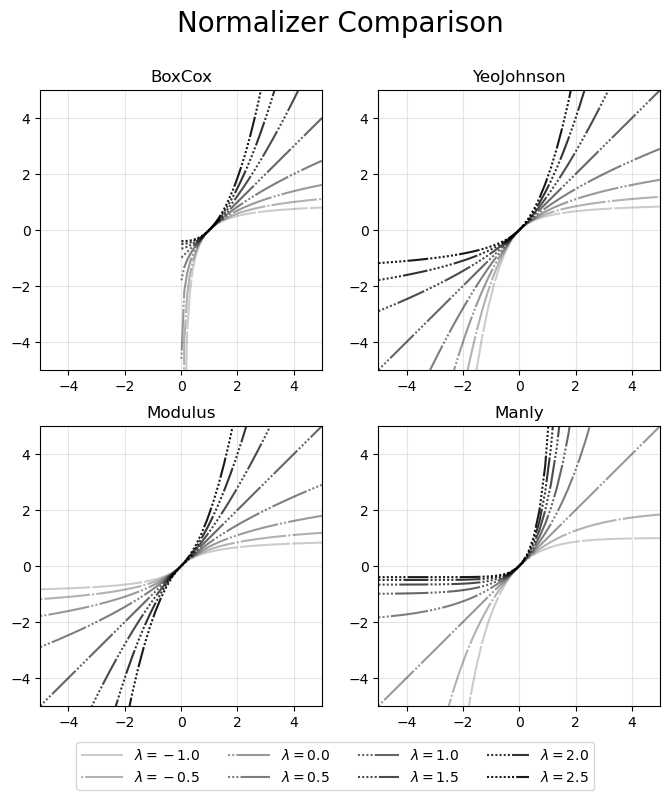

In [3]:
"""
Normalizer Comparison
---------------------

Let's compare the transformation behavior of the provided normalizers.

But first, we define a convenience routine and make some imports as always.
"""
import matplotlib.pyplot as plt
import numpy as np

import gstools as gs


def dashes(i=1, max_n=12, width=1):
    """Return line dashes."""
    return i * [width, width] + [max_n * 2 * width - 2 * i * width, width]


###############################################################################
# We select 4 normalizers depending on a single parameter lambda and
# plot their transformation behavior within the interval [-5, 5].
#
# For the shape parameter lambda, we create a list of 8 values ranging from
# -1 to 2.5.

lmbdas = [i * 0.5 for i in range(-2, 6)]
normalizers = [
    gs.normalizer.BoxCox,
    gs.normalizer.YeoJohnson,
    gs.normalizer.Modulus,
    gs.normalizer.Manly,
]

###############################################################################
# Let's plot them!

fig, ax = plt.subplots(2, 2, figsize=[8, 8])
for i, norm in enumerate(normalizers):
    # correctly setting the data range
    x_rng = norm().normalize_range
    x = np.linspace(max(-5, x_rng[0] + 0.01), min(5, x_rng[1] - 0.01))
    for j, lmbda in enumerate(lmbdas):
        ax.flat[i].plot(
            x,
            norm(lmbda=lmbda).normalize(x),
            label=r"$\lambda=" + str(lmbda) + "$",
            color="k",
            alpha=0.2 + j * 0.1,
            dashes=dashes(j),
        )
    # axis formatting
    ax.flat[i].grid(which="both", color="grey", linestyle="-", alpha=0.2)
    ax.flat[i].set_ylim((-5, 5))
    ax.flat[i].set_xlim((-5, 5))
    ax.flat[i].set_title(norm().name)
# figure formatting
handles, labels = ax.flat[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, handlelength=3.0)
fig.suptitle("Normalizer Comparison", fontsize=20)
fig.show()

###############################################################################
# The missing :any:`LogNormal` transformation is covered by the :any:`BoxCox`
# transformation for lambda=0. The :any:`BoxCoxShift` transformation is
# simply the :any:`BoxCox` transformation shifted on the X-axis.
